# Identifying Major Depressive Disorder in Older Adults Through Naturalistic Driving Behaviors and Machine Learning
- Test with participants were not using antidepressants
- by Chen Chen (c.chen2@wustl.edu) - 20250111

In [64]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    GridSearchCV, GroupKFold
)
from sklearn.metrics import (
    accuracy_score, precision_score, 
    recall_score, f1_score, roc_curve, roc_auc_score, auc
)
from sklearn.utils import resample
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from tableone import TableOne
import warnings
from sklearn.metrics import confusion_matrix

In [65]:
import sys
import sklearn
import xgboost
import tableone

In [66]:
# Check versions
print(sys.version)
print(sklearn.__version__)
print(xgboost.__version__)
print(tableone.__version__)

3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
1.5.1
2.1.1
0.9.1


In [67]:
# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Prepare functions 
my_encoder, my_split, evaluate_model, calculate_ci, my_bootstrap, find_x, default_fit, tune_params, fea_impor


In [68]:
# set the random seed as 42
my_random_state = 42
# folds
my_folds = 10
# model
my_xgb = XGBClassifier(random_state=my_random_state)
# set the cv to groupkfold
my_cv = GroupKFold(n_splits=my_folds)

# set the parameters that gridsearch needs to find
param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.15, 0.3], # range: [0,1], [default=0.3]
    'max_depth': [3, 4, 5, 6], # range: [0,∞], [default=6]
    'subsample': [0.6, 0.8, 1.0],  # range: (0,1], [default=1]
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2], # range: [0,∞], [default=1]
    'random_state': [my_random_state],
    #'lambda': [0, 0.1, 1, 10],
   # 'alpha': [0, 0.1, 1, 10]
}

In [69]:
# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

In [70]:
def my_encoder(df):
    # Use OnehotEncoder of Scikitlearn
    encoder = OneHotEncoder(sparse_output=False)
    #Extract categorical columns from the dataframe
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    # Apply one-hot encoding to the categorical columns
    one_hot_encoded = encoder.fit_transform(df[categorical_columns])
    #Create a DataFrame with the one-hot encoded columns
    # Ref: https://stackoverflow.com/questions/56338847/how-to-give-column-names-after-one-hot-encoding-with-sklearn
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
    # Concatenate the one-hot encoded dataframe with the original dataframe
    df_encoded = pd.concat([df, one_hot_df], axis=1)
    # Drop the original categorical columns
    df_encoded = df_encoded.drop(categorical_columns, axis=1)
    
    return df_encoded

In [71]:
def my_split(X, y, seed=my_random_state, train_size=0.7):
    """
    Splits data into training and testing sets based on unique participant IDs.
    """
    # Assign random seed seed
    rng = np.random.default_rng(seed)

    # Identify all unique participantId values
    unique_ids = X['participantId'].unique()

    # Shuffle the unique IDs
    rng.shuffle(unique_ids)

    # Determine the number of IDs for each set
    train_size = int( train_size * len(unique_ids) )

    # Assign sets by filtering based on IDs
    X_train = X[ X['participantId'].isin(unique_ids[:train_size])]
    X_test = X[ X['participantId'].isin(unique_ids[train_size:])]  

    y_train = y[ y['participantId'].isin(unique_ids[:train_size])]
    y_test = y[ y['participantId'].isin(unique_ids[train_size:])]

    return X_train, y_train, X_test, y_test

In [72]:
def evaluate_model(y_test, y_pred, y_pred_prob):
    """
    Calculate and print evaluation metrics for a model.
    """
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {roc_auc:.2f}")

In [73]:
def calculate_ci(data, confidence=0.95):
    """
    Calculate confidence interval
    """
    alpha = 1 - confidence  # Significance level
    lower_ci = np.percentile(data, alpha / 2 * 100)  # Lower bound, return 2.5th percentile
    upper_ci = np.percentile(data, (100 - alpha / 2 * 100))  # Upper bound, return 97.5th percentile
    return round(lower_ci, 2), round(upper_ci, 2)  # Round to 2 decimal points

In [74]:
def my_bootstrap(best_model, X_test, y_test, num_bootstraps=1000, sample_fraction=0.25):
    """
    Perform bootstrapping and calculate evaluation metrics with confidence intervals.
    """
    # Lists to store evaluation metrics
    accuracy = []
    precision = []
    recall = []
    specificity = [] 
    f1 = []
    roc_auc = []
    
    # Lists to store ROC curve data
    tprs = []
    fprs = []
    mean_fpr = np.linspace(0, 1, 100)  # Fixed FPR points for interpolation

    my_samples = int(sample_fraction * len(X_test))

    for i in range(num_bootstraps):
        # Resample the test data
        X_sample, y_sample = resample(X_test, y_test, n_samples=my_samples)

        # Predict on the bootstrapped sample using the trained model
        y_pred_prob = best_model.predict_proba(X_sample)[:, 1] 
        y_pred_best = best_model.predict(X_sample)
        
        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_sample, y_pred_best).ravel()

        # Calculate and store metrics
        accuracy.append(accuracy_score(y_sample, y_pred_best))
        precision.append(precision_score(y_sample, y_pred_best))
        recall.append(recall_score(y_sample, y_pred_best))
        specificity.append(tn / (tn + fp))  # Specificity calculation
        f1.append(f1_score(y_sample, y_pred_best))        
        roc_auc.append(roc_auc_score(y_sample, y_pred_prob))
        
        # Calculate ROC curve for the current bootstrap sample
        fpr, tpr, _ = roc_curve(y_sample, y_pred_prob)
        
        # Interpolate TPR at the fixed FPR points
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  
        tprs.append(interp_tpr)
        fprs.append(fpr)

    # Calculate CIs for each metric
    metrics_ci = {
        "accuracy": calculate_ci(accuracy),
        "precision": calculate_ci(precision),
        "recall": calculate_ci(recall),
        "specificity": calculate_ci(specificity), 
        "f1_score": calculate_ci(f1),
        "roc_auc": calculate_ci(roc_auc)
    }
    
    metrics_std = {
        "accuracy_std": np.std(accuracy),
        "precision_std": np.std(precision),
        "recall_std": np.std(recall),
        "specificity_std": np.std(specificity),
        "f1_score_std": np.std(f1),
        "roc_auc_std": np.std(roc_auc)
    }
    
    # Store metrics with two-digit formatting for table creation
    formatted_metrics = {
        "accuracy": round(np.mean(accuracy), 2),
        "precision": round(np.mean(precision), 2),
        "recall": round(np.mean(recall), 2),
        "specificity": round(np.mean(specificity), 2),
        "f1_score": round(np.mean(f1), 2),
        "roc_auc": round(np.mean(roc_auc), 2),
    }
    
    formatted_metrics_ci = {
        "accuracy_ci": metrics_ci["accuracy"],
        "precision_ci": metrics_ci["precision"],
        "recall_ci": metrics_ci["recall"],
        "specificity_ci": metrics_ci["specificity"],
        "f1_score_ci": metrics_ci["f1_score"],
        "roc_auc_ci": metrics_ci["roc_auc"]
    }

    formatted_metrics_std = {
        "accuracy_std": round(metrics_std["accuracy_std"], 2),
        "precision_std": round(metrics_std["precision_std"], 2),
        "recall_std": round(metrics_std["recall_std"], 2),
        "specificity_std": round(metrics_std["specificity_std"], 2),
        "f1_score_std": round(metrics_std["f1_score_std"], 2),
        "roc_auc_std": round(metrics_std["roc_auc_std"], 2),
    }
    

    # Print metrics, their confidence intervals, standard deviations, and maximum values
    print(f"Accuracy: {formatted_metrics['accuracy']}, CI: {formatted_metrics_ci['accuracy_ci']}, "
          f"Std Dev: {formatted_metrics_std['accuracy_std']}")
    
    print(f"Precision: {formatted_metrics['precision']}, CI: {formatted_metrics_ci['precision_ci']}, "
          f"Std Dev: {formatted_metrics_std['precision_std']}")
    
    print(f"Recall: {formatted_metrics['recall']}, CI: {formatted_metrics_ci['recall_ci']}, "
          f"Std Dev: {formatted_metrics_std['recall_std']}")
    
    print(f"Specificity: {formatted_metrics['specificity']}, CI: {formatted_metrics_ci['specificity_ci']}, "
          f"Std Dev: {formatted_metrics_std['specificity_std']}")
    
    print(f"F1 Score: {formatted_metrics['f1_score']}, CI: {formatted_metrics_ci['f1_score_ci']}, "
          f"Std Dev: {formatted_metrics_std['f1_score_std']}")
    
    print(f"ROC AUC: {formatted_metrics['roc_auc']}, CI: {formatted_metrics_ci['roc_auc_ci']}, "
          f"Std Dev: {formatted_metrics_std['roc_auc_std']}")

    return formatted_metrics, formatted_metrics_ci, formatted_metrics_std, np.array(tprs), mean_fpr

In [75]:
def find_x(fn, X_train, X_test): 
    """
    find train/test sets that matched to target variables
    """
    feature_names = fn
    X_train1 = X_train[feature_names]
    X_test1 = X_test[feature_names]
    return X_train1, X_test1

In [76]:
def default_fit(model, X_train, y_train, X_test, y_test):
    """
    fit the default model
    """
    model = my_xgb  
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    evaluate_model(y_test, y_pred, y_pred_prob)

In [77]:
# Create the GridSearchCV object
def tune_params(model, param_xgb, X_train, y_train, X_test, y_test, cv=my_cv, groups=None, scoring='recall', n_jobs=-1):
    """
    Use grid search to tune the model hyperparameters and return the best model and predictions.
    """
    # Perform grid search
    grid_xgb = GridSearchCV(estimator=model, 
                            param_grid=param_xgb, 
                            scoring=scoring, 
                            cv=my_cv, 
                            n_jobs=n_jobs)
    
    # Fit the grid search model on the training data
    grid_xgb.fit(X_train, y_train, groups=groups)
    
    # Get the best model from the grid search
    best_model = grid_xgb.best_estimator_
    
    # Print the best parameters found by grid search
    print("Best Parameters found: ", grid_xgb.best_params_)
    
    # Make predictions on the train set using the best model
    Train_y_pred_best = best_model.predict(X_train)
    Train_y_pred_prob_best = best_model.predict_proba(X_train)[:, 1]
    
    # Make predictions on the test set using the best model
    y_pred_best = best_model.predict(X_test)
    y_pred_prob_best = best_model.predict_proba(X_test)[:, 1] 
    
    print("model performance on train set")
    evaluate_model(y_train, Train_y_pred_best, Train_y_pred_prob_best)

    print("model performance on test set")
    evaluate_model(y_test, y_pred_best, y_pred_prob_best)
    
    return best_model, y_pred_best, y_pred_prob_best

In [78]:
# find feature importance by gain
def fea_impor(best_model, importance_type="gain", max_num_features=10, model_name="XGBoost"):
    """
    Plot feature importance for a tuned XGBoost model with color map.
    """
    
    # Extract feature importance
    feature_importance = best_model.get_booster().get_score(importance_type=importance_type)
    
    # Convert to DataFrame for sorting and plotting
    importance_df = pd.DataFrame(
        list(feature_importance.items()), columns=['Feature', 'Importance']
    ).sort_values(by='Importance', ascending=False)
    
    importance_df['Feature'] = importance_df['Feature'].map(feature_name_map).astype(str)
 
    # Create the color map
    colormap = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
    
    
    # Plot feature importance with different colors
    plt.figure(figsize=(12, 10))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color=colormap)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel(f'Feature Importance ({importance_type.capitalize()})')
    plt.ylabel('Features')
    plt.title(f'Top Important Features by {importance_type.capitalize()} - Model with {model_name}')
    plt.grid(True)
    plt.savefig(f'feature_importance{model_name}.png', bbox_inches='tight')
    plt.show()

### Create different feature sets 

In [79]:
# Seperate different sets of features
# Define a list of columns to drop
driving_features = [
 'nHardcoreBrake',
 'nHardcornering',
 'Days_driven_per_month',
 'nTrips_1mi',
 'nTrips_1to5mi',
 'randomEntropy',
 'radiusOfGyration',
 'maxDistanceFromHome',
 'maxDistance',
 'numberOfUniqueDestinations',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter'
]

demo_driving_features = [
 'gender_male',
 'gender_female',
 'educ',
 'age',
 'nHardcoreBrake',
 'nHardcornering',
 'Days_driven_per_month',
 'nTrips_1mi',
 'nTrips_1to5mi',
 'randomEntropy',
 'radiusOfGyration',
 'maxDistanceFromHome',
 'maxDistance',
 'numberOfUniqueDestinations',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter'
]

anti_driving_features = [
 'Antidepressant_yes',
 'Antidepressant_no',   
 'nHardcoreBrake',
 'nHardcornering',
 'Days_driven_per_month',
 'nTrips_1mi',
 'nTrips_1to5mi',
 'randomEntropy',
 'radiusOfGyration',
 'maxDistanceFromHome',
 'maxDistance',
 'numberOfUniqueDestinations',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter'
]

total_driving_features = [
 'Total',
 'nHardcoreBrake',
 'nHardcornering',
 'Days_driven_per_month',
 'nTrips_1mi',
 'nTrips_1to5mi',
 'randomEntropy',
 'radiusOfGyration',
 'maxDistanceFromHome',
 'maxDistance',
 'numberOfUniqueDestinations',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter'
]

anti_demo_driving_features = [
 'gender_male',
 'gender_female',
 'educ',
 'age',
 'Antidepressant_yes',
 'Antidepressant_no',
 'nHardcoreBrake',
 'nHardcornering',
 'Days_driven_per_month',
 'nTrips_1mi',
 'nTrips_1to5mi',
 'randomEntropy',
 'radiusOfGyration',
 'maxDistanceFromHome',
 'maxDistance',
 'numberOfUniqueDestinations',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter'
]

total_demo_driving_features = [
 'gender_male',
 'gender_female',
 'educ',
 'age',
 'Total',
 'nHardcoreBrake',
 'nHardcornering',
 'Days_driven_per_month',
 'nTrips_1mi',
 'nTrips_1to5mi',
 'randomEntropy',
 'radiusOfGyration',
 'maxDistanceFromHome',
 'maxDistance',
 'numberOfUniqueDestinations',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter'
]

In [80]:
# create a name map for plotting
feature_name_map = {
    'nHardcoreBrake': 'Rate of Hardcore Braking Events',
    'nHardcornering': 'Rate of Hard cornering Events',
    'Days_driven_per_month': 'Number of Days Driven',
    'nTrips_1mi': 'Number of Trips less than 1 mile',
    'nTrips_1to5mi': 'Number of Trips between 1 mile to 5 miles',
    'randomEntropy': 'Random Entropy',
    'radiusOfGyration': 'Radius of Gyration',
    'maxDistanceFromHome': 'Maximum Distance from Home',
    'maxDistance': 'Maximum of Distance',
    'numberOfUniqueDestinations': 'Number of Unique Destinations',
    'gender_male': 'Sex-male',
    'gender_female': 'Sex-female',
    'age': 'Age',
    'Antidepressant_yes': 'Antidepressants-yes',
    'Antidepressant_no': 'Antidepressants-no',
    'Total': 'Total classes of Medication',
    'educ': 'Years of education',
    'season_Fall': 'Fall',
    'season_Spring': 'Spring',
    'season_Summer': 'Summer',
    'season_Winter': 'Winter'
}

In [85]:
# Add season column
data = data.copy()
data['season'] = data['month'].apply(get_season)

In [88]:
# recode Antidepressant as object
data['Antidepressant'] = data['Antidepressant'].replace({1.0: 'yes', 
                                                         0.0: 'no'})

# drop unneeded variables in this analysis
df = data.drop(
    ['vehicleName','year','month'], axis=1).copy()

# recode dp to 0 and 1. 
df['dp'] = df['dp'].replace({'yes': 1, 'no': 0}).astype(int)

# recode gender to male and female. 1: male, 2: female
# https://redcap.wustl.edu/redcap/redcap_v14.0.34/Design/data_dictionary_codebook.php?pid=7842
df['gender'] = df['gender'].replace({1: 'male', 2: 'female'})

In [89]:
# encode the df
df_encoded = my_encoder(df)

In [90]:
df_encoded = df_encoded.copy()
df_encoded = df_encoded[df_encoded['Antidepressant_no'] == 1.0]
df_encoded.shape

(3070, 23)

In [92]:
columns_to_convert = [
    'gender_female',
    'gender_male',
    'Antidepressant_no',
    'Antidepressant_yes',
    'season_Fall',
    'season_Spring',
    'season_Summer',
    'season_Winter'
]

# Convert these columns to integers
df_encoded[columns_to_convert] = df_encoded[columns_to_convert].astype(int)

## Encoding & Train/Test split

In [94]:
# spilt X and y 
# drop dp in X and include id and dp to y
X = df_encoded.drop(['dp'], axis=1).copy()
y = df_encoded[['participantId', 'dp']].copy()

# apply my_split to X and y
splits = my_split(X, y, seed=my_random_state, train_size=0.7)
X_train, y_train, X_test, y_test = splits

In [95]:
# groups equals to the participant ids in the train set
groups = X_train['participantId'].values

In [96]:
# remove the key 'participantId'
X_train = X_train.drop('participantId', axis=1)
y_train = y_train.drop('participantId', axis=1)
X_test = X_test.drop('participantId', axis=1)
y_test = y_test.drop('participantId', axis=1) 

In [97]:
# phase 0
X_train0, X_test0 = find_x(driving_features, X_train, X_test)
# phase 1
X_train1, X_test1 = find_x(demo_driving_features, X_train, X_test)
# phase 2
X_train2, X_test2 = find_x(anti_driving_features, X_train, X_test)
X_train3, X_test3 = find_x(total_driving_features , X_train, X_test)
# phase 3
X_train4, X_test4 = find_x(anti_demo_driving_features, X_train, X_test)
X_train5, X_test5 = find_x(total_demo_driving_features, X_train, X_test)

### Check distribution

In [100]:
df_check_train = X_train.copy()
df_check_train['group'] = 'train'
df_check_train['dp'] = y_train

df_check_test = X_test.copy()
df_check_test['group'] = 'test'
df_check_test['dp'] = y_test

# Combine the two DataFrames
combined_data = pd.concat([df_check_train, df_check_test], ignore_index=True)

In [101]:
# Columns to include in the table
columns = ['nHardcoreBrake', 'nHardcornering',
       'Days_driven_per_month', 'nTrips_1mi', 'nTrips_1to5mi', 'randomEntropy',
       'radiusOfGyration', 'maxDistanceFromHome', 'maxDistance',
       'numberOfUniqueDestinations']  
groupby = 'group'  # stratify by group 
decimals = {'nHardcoreBrake': 3, 'nHardcornering': 3,'Days_driven_per_month':2, 'nTrips_1mi':2, 'nTrips_1to5mi':2, 'randomEntropy':2,
       'radiusOfGyration':2, 'maxDistanceFromHome':2, 'maxDistance':2,
       'numberOfUniqueDestinations':2
}
# Create TableOne
table_driving = TableOne(combined_data, columns=columns, 
                      #categorical=categorical, 
                      groupby=groupby, decimals=decimals, pval=True)

# Print 
print(table_driving.tabulate(tablefmt="fancy_grid"))

╒═══════════════════════════════════════╤════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                                       │    │ Missing   │ Overall          │ test             │ train            │ P-Value   │
╞═══════════════════════════════════════╪════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                                     │    │           │ 3070             │ 930              │ 2140             │           │
├───────────────────────────────────────┼────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ nHardcoreBrake, mean (SD)             │    │ 0         │ 0.001 (0.003)    │ 0.001 (0.003)    │ 0.001 (0.003)    │ 0.623     │
├───────────────────────────────────────┼────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ nHardcornering, mean (SD)             │    │ 0         │ 0.025 (0.053)    │ 0.030 (0.064)    │ 0.023 (

In [103]:
# Columns to include in the table
columns = ['dp','age', 'gender_female', 
           'Antidepressant_yes',
           'educ', 'Total']  
categorical = ['dp', 'gender_female', 
               #'Antidepressant_yes'
              ]  
groupby = 'group'  # stratify by dp 
decimals = {
    'age': 2,
    'gender_female': 2,
    'educ': 2,
    'Total': 2,
    'Antidepressant_yes': 2
}
# Create TableOne
table_demo = TableOne(combined_data, columns=columns, categorical=categorical, groupby=groupby, decimals=decimals, pval=True)

# Print 
print(table_demo.tabulate(tablefmt="fancy_grid"))

╒═══════════════════════════════╤════╤═══════════╤══════════════╤══════════════╤══════════════╤═══════════╕
│                               │    │ Missing   │ Overall      │ test         │ train        │ P-Value   │
╞═══════════════════════════════╪════╪═══════════╪══════════════╪══════════════╪══════════════╪═══════════╡
│ n                             │    │           │ 3070         │ 930          │ 2140         │           │
├───────────────────────────────┼────┼───────────┼──────────────┼──────────────┼──────────────┼───────────┤
│ dp, n (%)                     │ 0  │           │ 1658 (54.0)  │ 547 (58.8)   │ 1111 (51.9)  │ <0.001    │
├───────────────────────────────┼────┼───────────┼──────────────┼──────────────┼──────────────┼───────────┤
│                               │ 1  │           │ 1412 (46.0)  │ 383 (41.2)   │ 1029 (48.1)  │           │
├───────────────────────────────┼────┼───────────┼──────────────┼──────────────┼──────────────┼───────────┤
│ age, mean (SD)            

### Fit default model

In [105]:
# List of phase descriptions
phase_descriptions = [
    "Driving Features", #0
    "Demographics + Driving Features", #1
    "Antidepressant + Driving Features", #2
    "Total + Driving Features", #3
    "Antidepressant + Demographics + Driving Features",#4
    "Total + Demographics + Driving Features"#5
]

# List of train and test data frames
train_dfs = [X_train0, X_train1, X_train2, X_train3, X_train4, X_train5]
test_dfs = [X_test0, X_test1, X_test2, X_test3, X_test4, X_test5]

In [106]:
# Loop through each phase and apply default_fit
for i in range(len(phase_descriptions)):
    print(f"Phase {i}: {phase_descriptions[i]}")
    default_fit(my_xgb, train_dfs[i], y_train, test_dfs[i], y_test)
    print('\n')

Phase 0: Driving Features
Accuracy: 0.74
Precision: 0.66
Recall: 0.76
F1 Score: 0.71
AUC-ROC: 0.81


Phase 1: Demographics + Driving Features
Accuracy: 0.81
Precision: 0.75
Recall: 0.81
F1 Score: 0.78
AUC-ROC: 0.91


Phase 2: Antidepressant + Driving Features
Accuracy: 0.74
Precision: 0.66
Recall: 0.76
F1 Score: 0.71
AUC-ROC: 0.81


Phase 3: Total + Driving Features
Accuracy: 0.75
Precision: 0.67
Recall: 0.78
F1 Score: 0.72
AUC-ROC: 0.81


Phase 4: Antidepressant + Demographics + Driving Features
Accuracy: 0.81
Precision: 0.75
Recall: 0.81
F1 Score: 0.78
AUC-ROC: 0.91


Phase 5: Total + Demographics + Driving Features
Accuracy: 0.82
Precision: 0.76
Recall: 0.82
F1 Score: 0.79
AUC-ROC: 0.90




### GridSearchCV

In [107]:
%%time
# List to store model results
results = []

# Loop through each phase and apply tune_params
for i in range(len(phase_descriptions)):
    print(f"Phase {i}: {phase_descriptions[i]}")
    
    # Run tune_params for each phase
    best_model, y_pred_best, y_pred_prob_best = tune_params(
        my_xgb, param_xgb, train_dfs[i], y_train, test_dfs[i], y_test, cv=my_cv, groups=groups, scoring='recall', n_jobs=-1
    )
    
    # Store the results in a dictionary
    result_dict = {
        'best_model': best_model,

        'y_pred_best': y_pred_best,
        'y_pred_prob_best': y_pred_prob_best
    }
    results.append(result_dict)
    
    print('\n')

Phase 0: Driving Features
Best Parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.6}
model performance on train set
Accuracy: 0.78
Precision: 0.76
Recall: 0.79
F1 Score: 0.77
AUC-ROC: 0.85
model performance on test set
Accuracy: 0.83
Precision: 0.77
Recall: 0.85
F1 Score: 0.81
AUC-ROC: 0.85


Phase 1: Demographics + Driving Features
Best Parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.8}
model performance on train set
Accuracy: 0.96
Precision: 0.98
Recall: 0.94
F1 Score: 0.96
AUC-ROC: 0.99
model performance on test set
Accuracy: 0.84
Precision: 0.82
Recall: 0.77
F1 Score: 0.79
AUC-ROC: 0.92


Phase 2: Antidepressant + Driving Features
Best Parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'random_state': 42, 'subsampl

### Plot feature importance

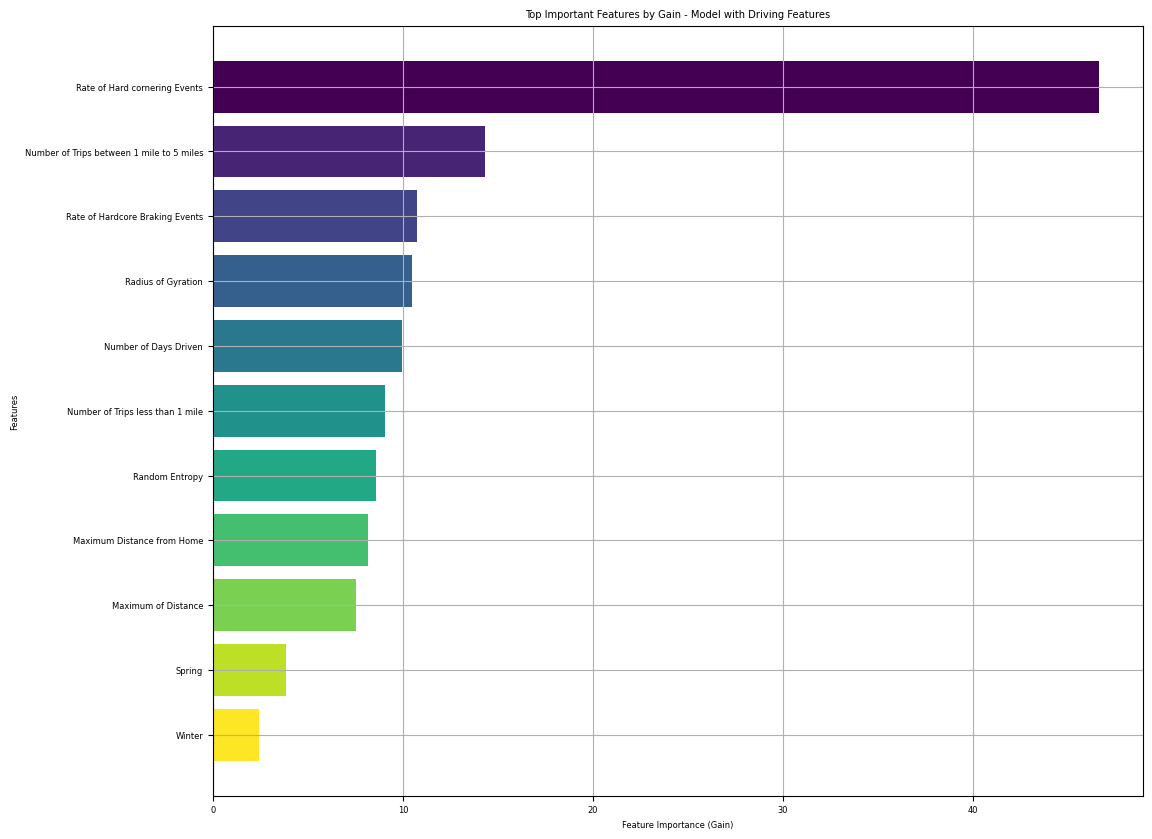

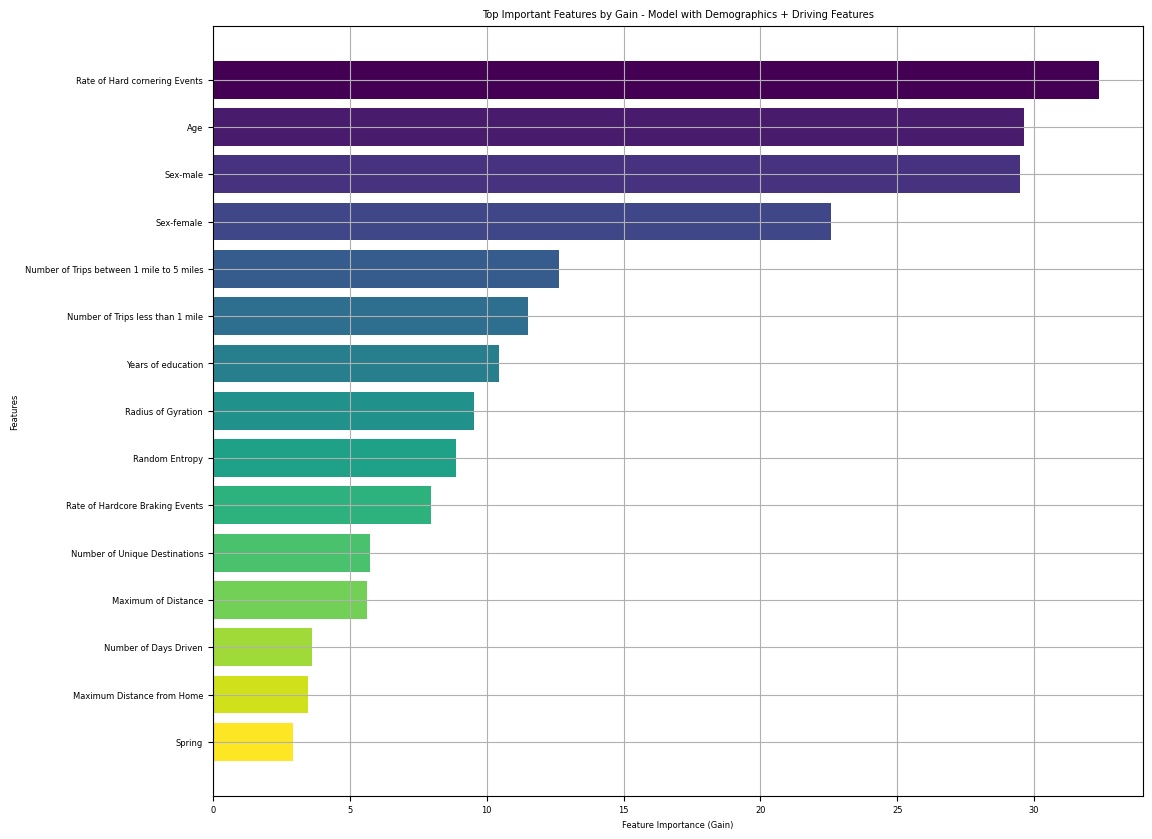

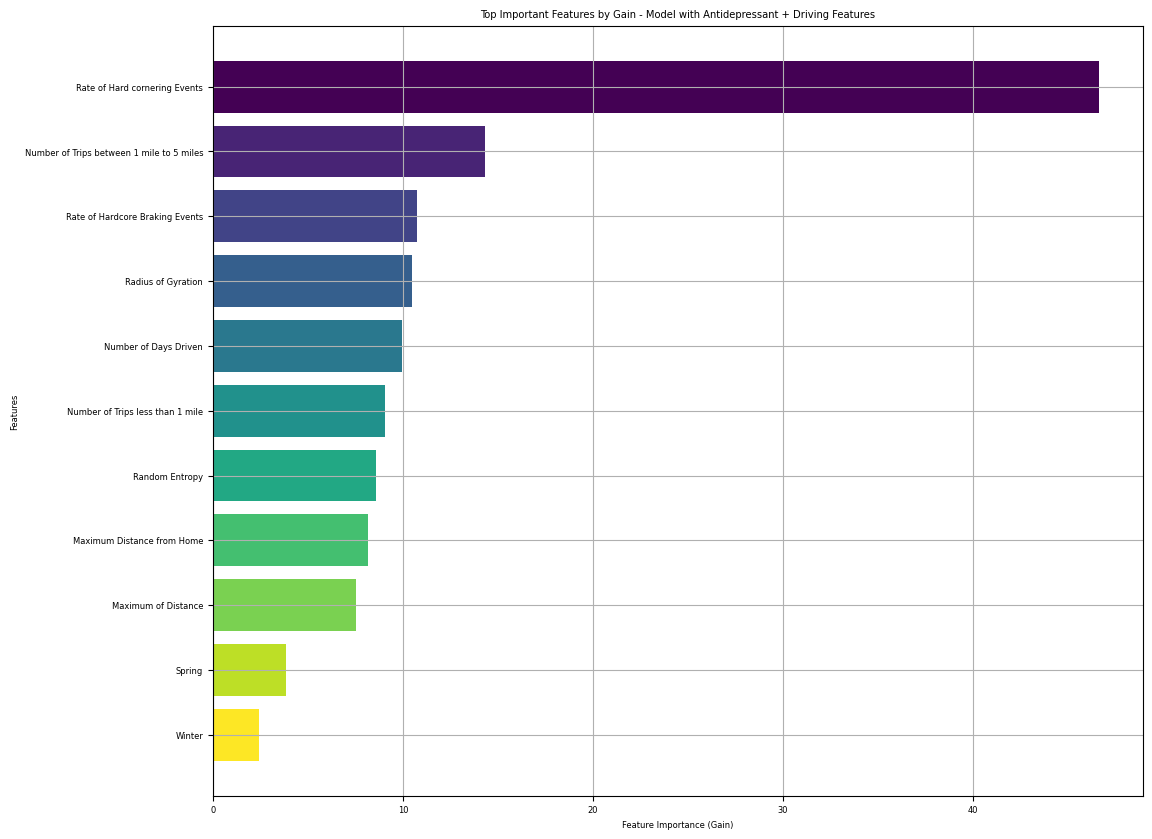

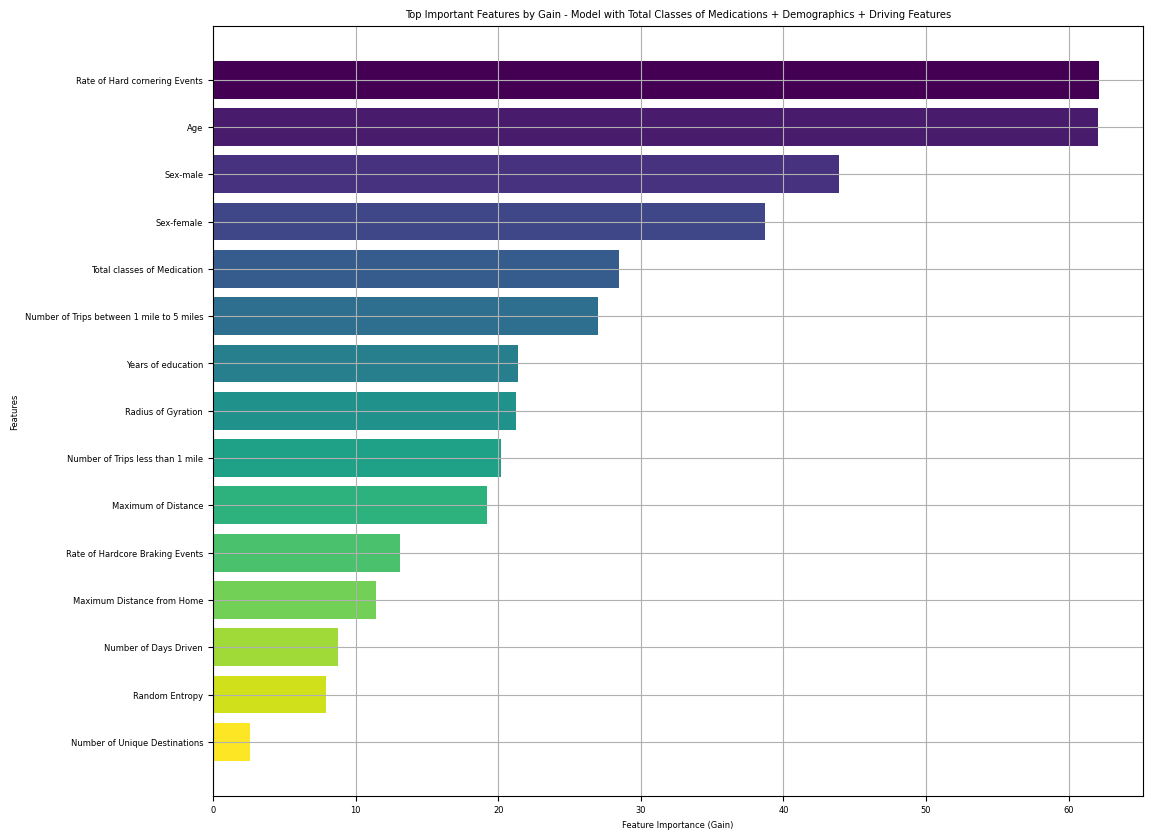

In [108]:
# plot feature importance
fea_impor(results[0]['best_model'], importance_type="gain", max_num_features=None, model_name='Driving Features')
fea_impor(results[1]['best_model'], importance_type="gain", max_num_features=None, model_name='Demographics + Driving Features')
fea_impor(results[2]['best_model'], importance_type="gain", max_num_features=None, model_name='Antidepressant + Driving Features')
#fea_impor(results[3]['best_model'], importance_type="gain", max_num_features=None, model_name='Total Classes of Medications + Driving Features')
#fea_impor(results[4]['best_model'], importance_type="gain", max_num_features=None, model_name='Antidepressant + Demographics + Driving Features')
fea_impor(results[5]['best_model'], importance_type="gain", max_num_features=None, model_name='Total Classes of Medications + Demographics + Driving Features')
feature_importance = results[5]['best_model'].get_booster().get_score(importance_type='gain')
#print(feature_importance)

### Bootstrapping

In [109]:
%%time
# Phase 0 (Driving Features)
print("Phase 0: Driving Features")
formatted_metrics_0, metrics_ci_0, metrics_std_0, tprs_0, mean_fpr_0 = my_bootstrap(
    results[0]['best_model'], X_test0, y_test, num_bootstraps=1000, sample_fraction=0.25
)


Phase 0: Driving Features
Accuracy: 0.83, CI: (np.float64(0.78), np.float64(0.88)), Std Dev: 0.03
Precision: 0.77, CI: (np.float64(0.68), np.float64(0.85)), Std Dev: 0.04
Recall: 0.85, CI: (np.float64(0.77), np.float64(0.92)), Std Dev: 0.04
Specificity: 0.82, CI: (np.float64(0.75), np.float64(0.89)), Std Dev: 0.03
F1 Score: 0.81, CI: (np.float64(0.74), np.float64(0.86)), Std Dev: 0.03
ROC AUC: 0.85, CI: (np.float64(0.8), np.float64(0.91)), Std Dev: 0.03
CPU times: user 21min 44s, sys: 1.12 s, total: 21min 45s
Wall time: 38.2 s


In [110]:
%%time
# Phase 1 (Demographics + Driving Features)
print("Phase 1: Demographics + Driving Features")
formatted_metrics_1, metrics_ci_1, metrics_std_1, tprs_1, mean_fpr_1 = my_bootstrap(
    results[1]['best_model'], X_test1, y_test, num_bootstraps=1000, sample_fraction=0.25
)

Phase 1: Demographics + Driving Features
Accuracy: 0.84, CI: (np.float64(0.79), np.float64(0.89)), Std Dev: 0.03
Precision: 0.82, CI: (np.float64(0.74), np.float64(0.9)), Std Dev: 0.04
Recall: 0.77, CI: (np.float64(0.68), np.float64(0.85)), Std Dev: 0.04
Specificity: 0.88, CI: (np.float64(0.83), np.float64(0.94)), Std Dev: 0.03
F1 Score: 0.79, CI: (np.float64(0.73), np.float64(0.85)), Std Dev: 0.03
ROC AUC: 0.92, CI: (np.float64(0.89), np.float64(0.95)), Std Dev: 0.02
CPU times: user 26min 20s, sys: 977 ms, total: 26min 20s
Wall time: 43.7 s


In [111]:
%%time
# Phase 2 (Antidepressant + Driving Features)
print("Phase 2: Antidepressant + Driving Features")
formatted_metrics_2, metrics_ci_2, metrics_std_2, tprs_2, mean_fpr_2 = my_bootstrap(
    results[2]['best_model'], X_test2, y_test, num_bootstraps=1000, sample_fraction=0.25
)

Phase 2: Antidepressant + Driving Features
Accuracy: 0.83, CI: (np.float64(0.78), np.float64(0.88)), Std Dev: 0.02
Precision: 0.77, CI: (np.float64(0.69), np.float64(0.85)), Std Dev: 0.04
Recall: 0.84, CI: (np.float64(0.77), np.float64(0.91)), Std Dev: 0.04
Specificity: 0.82, CI: (np.float64(0.76), np.float64(0.88)), Std Dev: 0.03
F1 Score: 0.8, CI: (np.float64(0.74), np.float64(0.86)), Std Dev: 0.03
ROC AUC: 0.85, CI: (np.float64(0.8), np.float64(0.91)), Std Dev: 0.03
CPU times: user 19min 11s, sys: 885 ms, total: 19min 12s
Wall time: 35.9 s


In [112]:
%%time
# Phase 3 (Total + Driving Features)
print("Phase 3: Total + Driving Features")
formatted_metrics_3, metrics_ci_3, metrics_std_3, tprs_3, mean_fpr_3 = my_bootstrap(
    results[3]['best_model'], X_test3, y_test, num_bootstraps=1000, sample_fraction=0.25
)

Phase 3: Total + Driving Features
Accuracy: 0.81, CI: (np.float64(0.75), np.float64(0.86)), Std Dev: 0.03
Precision: 0.71, CI: (np.float64(0.63), np.float64(0.79)), Std Dev: 0.04
Recall: 0.88, CI: (np.float64(0.81), np.float64(0.94)), Std Dev: 0.03
Specificity: 0.75, CI: (np.float64(0.68), np.float64(0.82)), Std Dev: 0.04
F1 Score: 0.79, CI: (np.float64(0.72), np.float64(0.85)), Std Dev: 0.03
ROC AUC: 0.84, CI: (np.float64(0.79), np.float64(0.9)), Std Dev: 0.03
CPU times: user 21min 33s, sys: 928 ms, total: 21min 34s
Wall time: 38.1 s


In [113]:
%%time
# Phase 4 (Antidepressant + Demographics + Driving Features)
print("Phase 4: Antidepressant + Demographics + Driving Features")
formatted_metrics_4, metrics_ci_4, metrics_std_4,  tprs_4, mean_fpr_4 = my_bootstrap(
    results[4]['best_model'], X_test4, y_test, num_bootstraps=1000, sample_fraction=0.25
)

Phase 4: Antidepressant + Demographics + Driving Features
Accuracy: 0.84, CI: (np.float64(0.79), np.float64(0.88)), Std Dev: 0.02
Precision: 0.83, CI: (np.float64(0.75), np.float64(0.9)), Std Dev: 0.04
Recall: 0.77, CI: (np.float64(0.68), np.float64(0.85)), Std Dev: 0.04
Specificity: 0.89, CI: (np.float64(0.83), np.float64(0.94)), Std Dev: 0.03
F1 Score: 0.8, CI: (np.float64(0.73), np.float64(0.86)), Std Dev: 0.03
ROC AUC: 0.91, CI: (np.float64(0.87), np.float64(0.94)), Std Dev: 0.02
CPU times: user 25min 26s, sys: 1.36 s, total: 25min 28s
Wall time: 43.2 s


In [114]:
%%time
# Phase 5 (Total + Demographics + Driving Features)
print("Phase 5: Total + Demographics + Driving Features")
formatted_metrics_5, metrics_ci_5, metrics_std_5, tprs_5, mean_fpr_5 = my_bootstrap(
    results[5]['best_model'], X_test5, y_test, num_bootstraps=1000, sample_fraction=0.25
)

Phase 5: Total + Demographics + Driving Features
Accuracy: 0.86, CI: (np.float64(0.81), np.float64(0.9)), Std Dev: 0.02
Precision: 0.82, CI: (np.float64(0.75), np.float64(0.89)), Std Dev: 0.04
Recall: 0.84, CI: (np.float64(0.76), np.float64(0.91)), Std Dev: 0.04
Specificity: 0.87, CI: (np.float64(0.82), np.float64(0.92)), Std Dev: 0.03
F1 Score: 0.83, CI: (np.float64(0.77), np.float64(0.88)), Std Dev: 0.03
ROC AUC: 0.96, CI: (np.float64(0.93), np.float64(0.98)), Std Dev: 0.01
CPU times: user 23min 6s, sys: 1.19 s, total: 23min 7s
Wall time: 40.5 s


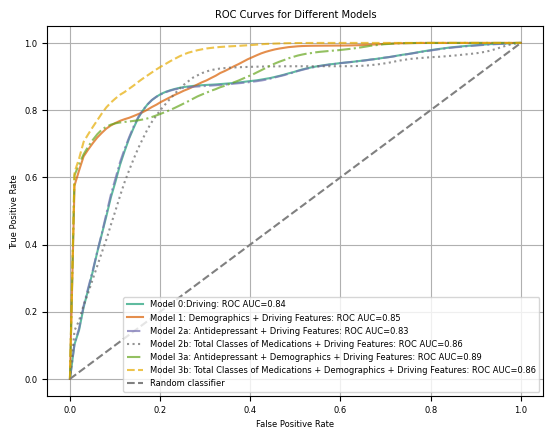

In [115]:
# Calculate the mean and standard deviation for TPR
mean_tpr_0 = np.mean(tprs_0, axis=0)
std_tpr_0 = np.std(tprs_0, axis=0)

mean_tpr_1 = np.mean(tprs_1, axis=0)
std_tpr_1 = np.std(tprs_1, axis=0)

mean_tpr_2 = np.mean(tprs_2, axis=0)
std_tpr_2 = np.std(tprs_2, axis=0)

mean_tpr_3 = np.mean(tprs_3, axis=0)
std_tpr_3 = np.std(tprs_3, axis=0)

mean_tpr_4 = np.mean(tprs_4, axis=0)
std_tpr_4 = np.std(tprs_4, axis=0)

mean_tpr_5 = np.mean(tprs_5, axis=0)
std_tpr_5 = np.std(tprs_5, axis=0)


colors = plt.get_cmap('Dark2').colors 
# Plot the ROC curve with confidence intervals
plt.plot(mean_fpr_0, mean_tpr_0, color=colors[0], linestyle='-', alpha=0.7, label=f'Model 0:Driving: ROC AUC=0.84')

# Phase 1
plt.plot(mean_fpr_1, mean_tpr_1, color=colors[1], linestyle='-', alpha=0.7, label=f'Model 1: Demographics + Driving Features: ROC AUC=0.85')

# Phase 2a
plt.plot(mean_fpr_2, mean_tpr_2, color=colors[2], linestyle='-.', alpha=0.7, label=f'Model 2a: Antidepressant + Driving Features: ROC AUC=0.83')

# Phase 2b
plt.plot(mean_fpr_3, mean_tpr_3, color=colors[7], linestyle=':', alpha=0.7, label=f'Model 2b: Total Classes of Medications + Driving Features: ROC AUC=0.86')

# Phase 3a
plt.plot(mean_fpr_4, mean_tpr_4, color=colors[4], linestyle='-.',alpha=0.7, label=f'Model 3a: Antidepressant + Demographics + Driving Features: ROC AUC=0.89')

# Phase 3b
plt.plot(mean_fpr_5, mean_tpr_5, color=colors[5], linestyle='--', alpha=0.7, label=f'Model 3b: Total Classes of Medications + Demographics + Driving Features: ROC AUC=0.86')

# Plot the diagonal (random guessing) line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random classifier')

plt.rcParams.update({'font.size': 6})
plt.title('ROC Curves for Different Models')

# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend and grid
plt.legend()
plt.grid()

plt.savefig('auc_fig_no_anti.png',dpi=600)

# Display the plot
plt.show()

# NOTE: the AUC SCORE WAS NOT UPDATE in the output figure

## Ranking

In [116]:
data_performance = {
    'Phase': ['Driving Features', 
              'Demographics + Driving Features', 
              'Antidepressant + Driving Features', 
              'Total + Driving Features', 
              'Antidepressant + Demographics + Driving Features', 
              'Total + Demographics + Driving Features'],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
}

# List of formatted_metrics for each phase
all_phases_metrics = [
    formatted_metrics_0,  # Replace this with metrics for "Driving Features"
    formatted_metrics_1,  # Replace this with metrics for "Demographics + Driving Features"
    formatted_metrics_2,  # Replace this with metrics for "Antidepressant + Driving Features"
    formatted_metrics_3,  # Replace this with metrics for "Total + Driving Features"
    formatted_metrics_4,  # Replace this with metrics for "Antidepressant + Demographics + Driving Features"
    formatted_metrics_5,  # Replace this with metrics for "Total + Demographics + Driving Features"
]

# Populate the metrics for each phase
for metrics in all_phases_metrics:
    data_performance['Precision'].append(metrics['precision'])
    data_performance['Recall'].append(metrics['recall'])
    data_performance['F1 Score'].append(metrics['f1_score'])
    data_performance['ROC AUC'].append(metrics['roc_auc'])

# Display the dictionary
print(data_performance)

{'Phase': ['Driving Features', 'Demographics + Driving Features', 'Antidepressant + Driving Features', 'Total + Driving Features', 'Antidepressant + Demographics + Driving Features', 'Total + Demographics + Driving Features'], 'Precision': [np.float64(0.77), np.float64(0.82), np.float64(0.77), np.float64(0.71), np.float64(0.83), np.float64(0.82)], 'Recall': [np.float64(0.85), np.float64(0.77), np.float64(0.84), np.float64(0.88), np.float64(0.77), np.float64(0.84)], 'F1 Score': [np.float64(0.81), np.float64(0.79), np.float64(0.8), np.float64(0.79), np.float64(0.8), np.float64(0.83)], 'ROC AUC': [np.float64(0.85), np.float64(0.92), np.float64(0.85), np.float64(0.84), np.float64(0.91), np.float64(0.96)]}


In [117]:
df_pf = pd.DataFrame(data_performance)

In [118]:
# create ranks
df_pf['Precision Rank'] = df_pf['Precision'].rank(ascending=False)
df_pf['Recall Rank'] = df_pf['Recall'].rank(ascending=False)
df_pf['F1 Score Rank'] = df_pf['F1 Score'].rank(ascending=False)
df_pf['ROC AUC Rank'] = df_pf['ROC AUC'].rank(ascending=False)

# show the results
df_pf

,Phase,Precision,Recall,F1 Score,ROC AUC,Precision Rank,Recall Rank,F1 Score Rank,ROC AUC Rank
0,Driving Features,0.77,0.85,0.81,0.85,4.5,2.0,2.0,4.5
1,Demographics + Driving Features,0.82,0.77,0.79,0.92,2.5,5.5,5.5,2.0
2,Antidepressant + Driving Features,0.77,0.84,0.80,0.85,4.5,3.5,3.5,4.5
3,Total + Driving Features,0.71,0.88,0.79,0.84,6.0,1.0,5.5,6.0
4,Antidepressant + Demographics + Driving Features,0.83,0.77,0.80,0.91,1.0,5.5,3.5,3.0
5,Total + Demographics + Driving Features,0.82,0.84,0.83,0.96,2.5,3.5,1.0,1.0


In [121]:
# Calculate the mean rank per model
df_pf['Mean Rank'] = df_pf[['Precision Rank', 'Recall Rank', 'F1 Score Rank', 'ROC AUC Rank']].mean(axis=1)

# Sort the models based on their mean rank
df_perform_sorted = df_pf.sort_values(by='Mean Rank')
#df_perform_sorted = df_pf.sort_index(ascending=True)
df_perform_sorted

,Phase,Precision,Recall,F1 Score,ROC AUC,Precision Rank,Recall Rank,F1 Score Rank,ROC AUC Rank,Mean Rank
5,Total + Demographics + Driving Features,0.82,0.84,0.83,0.96,2.5,3.5,1.0,1.0,2.000
0,Driving Features,0.77,0.85,0.81,0.85,4.5,2.0,2.0,4.5,3.250
4,Antidepressant + Demographics + Driving Features,0.83,0.77,0.80,0.91,1.0,5.5,3.5,3.0,3.250
1,Demographics + Driving Features,0.82,0.77,0.79,0.92,2.5,5.5,5.5,2.0,3.875
2,Antidepressant + Driving Features,0.77,0.84,0.80,0.85,4.5,3.5,3.5,4.5,4.000
3,Total + Driving Features,0.71,0.88,0.79,0.84,6.0,1.0,5.5,6.0,4.625
